# Modelling tabular data
> After completing the data retrieval and cleaning we here deal with how to set up basic models.

In [ ]:
#default_exp modelling

In [ ]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
import pandas as pd
from fastai2.tabular.all import *
from fastai2 import metrics
from sklearn import ensemble
import pickle
from typing import List
from kaggle_house_prices.utils import *
from kaggle_house_prices.preprocessing import *
import matplotlib as mpl

In [ ]:
mpl.style.use("bmh")

## Setting up the `TabularDataLoader`

The data loader is required to feed data into the learner during training

In [ ]:
procs = [Categorify, FillMissing, Normalize]

In [ ]:
with open(model_data_path, "rb") as f:
    to = pickle.load(f)

Get `splits` object for `TabularPandas`

In [ ]:
#hide
to.valid.ys.head()

,SalePrice
934,12.396693
710,10.858999
1026,12.028739
153,12.367341
994,12.729321


Creating the data loader

In [ ]:
dls = to.dataloaders()

In [ ]:
#hide
dls.show_batch()

,Id,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,GarageYrBlt_na,LotFrontage_na,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,LotFrontage,BsmtFinSF1,LowQualFinSF,SalePrice
0,266,20,RL,Pave,#na#,IR1,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,Gable,CompShg,MetalSd,MetalSd,BrkFace,TA,Gd,CBlock,Gd,TA,No,GLQ,LwQ,GasA,TA,Y,SBrkr,0,0,2,0,3,1,Gd,7,Typ,1,TA,Attchd,Fin,2,TA,TA,Y,0,0,0,0,#na#,GdPrv,#na#,0,6,WD,Normal,False,False,12090.000067,1981.000000,1981.000000,210.000002,228.000004,606.000000,1421.999989,1422.000006,0.000010,1422.000001,1981.000000,575.999999,2.760000e+02,-0.000001,78.000000,588.000003,1.280123e-08,12.075395
1,1233,90,RL,Pave,#na#,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,Duplex,1Story,4,5,Gable,CompShg,HdBoard,HdBoard,None,TA,TA,Slab,#na#,#na#,#na#,#na#,#na#,GasA,TA,Y,SBrkr,0,0,2,0,2,2,TA,6,Typ,0,#na#,CarPort,Unf,2,TA,TA,Y,0,0,0,0,#na#,#na#,#na#,0,3,WD,Normal,False,False,9841.999993,1962.000000,1961.999999,-0.000001,-0.000001,-0.000014,0.000021,1223.999998,0.000010,1223.999997,1962.000000,462.000000,-1.468373e-07,-0.000001,70.000000,-0.000006,1.280123e-08,11.530766
2,451,30,RM,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,6,8,Hip,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,BrkTil,TA,TA,No,Unf,Unf,GasA,Ex,Y,FuseA,0,0,1,0,2,1,Gd,5,Typ,0,#na#,Detchd,Unf,1,Fa,Fa,N,0,0,0,0,#na#,#na#,#na#,0,6,WD,Normal,False,False,5684.000122,1930.000001,2005.000000,-0.000001,-0.000001,813.000003,812.999990,812.999991,0.000010,813.000006,1932.000003,269.999999,-1.468373e-07,113.000001,70.000000,-0.000006,1.280123e-08,11.608235
3,669,20,RL,Pave,#na#,Reg,Bnk,AllPub,Corner,Mod,Sawyer,Norm,Norm,1Fam,1Story,5,6,Gable,CompShg,CemntBd,Wd Sdng,None,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,Gd,Y,SBrkr,1,0,1,1,3,1,TA,6,Min2,1,TA,Detchd,Unf,2,TA,TA,Y,0,0,0,0,#na#,#na#,#na#,0,11,WD,Normal,False,True,14175.000181,1956.000000,1987.000000,-0.000001,-0.000001,200.000013,1187.999996,1437.000008,0.000010,1437.000000,1999.000000,575.999999,3.040000e+02,-0.000001,65.000000,987.999988,1.280123e-08,12.031719
4,857,80,RL,Pave,#na#,IR1,Low,AllPub,Inside,Mod,CollgCr,Norm,Norm,1Fam,SLvl,6,6,Gable,CompShg,Plywood,HdBoard,None,TA,TA,CBlock,Gd,Gd,Gd,GLQ,LwQ,GasA,TA,Y,SBrkr,1,0,1,0,3,1,TA,5,Typ,0,#na#,Detchd,Unf,2,TA,Fa,Y,34,0,0,0,#na#,MnPrv,#na#,0,10,WD,Normal,False,True,10969.999979,1978.000000,1978.000000,-0.000001,434.999993,-0.000014,939.999998,1026.000001,0.000010,1026.000001,1981.000000,575.999999,-1.468373e-07,-0.000001,65.000000,505.000000,1.280123e-08,11.898188
5,626,20,RL,Pave,#na#,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,TA,Y,SBrkr,0,0,1,1,3,1,TA,5,Typ,0,#na#,Attchd,Unf,2,TA,TA,Y,0,0,385,0,#na#,#na#,#na#,0,2,WD,Normal,False,False,10000.000012,1962.000000,1961.999999,260.999996,-0.000001,1116.000027,1116.000001,1116.000000,0.000010,1115.999994,1962.000000,440.000000,-1.468373e-07,-0.000001,86.999999,-0.000006,1.280123e-08,11.982929
6,1425,20,RL,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,Hip,CompShg,HdBoard,HdBoard,None,TA,TA,CBlock,TA,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,1,0,1,0,2,1,TA,6,Min1,1,TA,Detchd,Unf,1,TA,TA,Y,0,0,0,0,#na#,GdWo,#na#,0,6,WD,Normal,False,True,9502.999997,1958.000000,1983.000000,-0.000001,373.999993,192.999998,1024.000000,13

## Setting up the `Learner`

The main function to set up a learner for tabular data is fastai's [`tabular_learner`](https://github.com/fastai/fastai2/blob/master/fastai2/tabular/learner.py) function, which is based on the [`Learner`](https://dev.fast.ai/learner#Learner) class.

In [ ]:
#export
def mish(x:torch.Tensor) -> torch.Tensor:
    return x * torch.tanh(F.softplus(x))

class Mish(torch.nn.Module):
    "Mish activation function: arXiv:1908.08681"
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return mish(input)

Modifying the [`TabularModel`](https://dev.fast.ai/tabular.model#TabularModel) class so it can take any non-linear activation functions

In [ ]:
#export
@patch
def __init__(self:TabularModel, emb_szs, n_cont, out_sz, layers, ps=None, embed_p=0.,
             y_range=None, use_bn=True, bn_final=False, bn_cont=True, active_fun:nn.Module=None):        
    ps = ifnone(ps, [0]*len(layers))
    if not is_listy(ps): ps = [ps]*len(layers)
    self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
    self.emb_drop = nn.Dropout(embed_p)
    self.bn_cont = nn.BatchNorm1d(n_cont) if bn_cont else None
    n_emb = sum(e.embedding_dim for e in self.embeds)
    self.n_emb,self.n_cont = n_emb,n_cont
    sizes = [n_emb + n_cont] + layers + [out_sz]
    # actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
    actns = [active_fun() for _ in range(len(sizes)-2)] + [None]
    _layers = [LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and (i!=len(actns)-1 or bn_final), p=p,act=a)
               for i,(p,a) in enumerate(zip(ps+[0.],actns))] 
    if y_range is not None: _layers.append(SigmoidRange(*y_range))
    self.layers = nn.Sequential(*_layers)

Defining the loss function

In [ ]:
loss_fun = torch.nn.functional.mse_loss

Collecting the range of `dep_var` values

In [ ]:
y_range = [min(to.valid.ys.values.min(), to.train.ys.values.min()), 
           max(to.valid.ys.values.max(), to.train.ys.values.max())]; y_range

[10.858998997563564, 12.885202034321916]

Setting up the customized tabular learner

In [ ]:
%%time
learn = tabular_learner(dls, n_out=1, loss_func=loss_fun, config=dict(active_fun=Mish),
                        y_range=y_range)

CPU times: user 16.9 ms, sys: 47 µs, total: 16.9 ms
Wall time: 17.1 ms


In [ ]:
#hide
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1461, 95)
    (1): Embedding(16, 8)
    (2): Embedding(6, 4)
    (3): Embedding(3, 3)
    (4): Embedding(3, 3)
    (5): Embedding(5, 4)
    (6): Embedding(5, 4)
    (7): Embedding(3, 3)
    (8): Embedding(6, 4)
    (9): Embedding(4, 3)
    (10): Embedding(26, 10)
    (11): Embedding(10, 6)
    (12): Embedding(9, 5)
    (13): Embedding(6, 4)
    (14): Embedding(9, 5)
    (15): Embedding(11, 6)
    (16): Embedding(10, 6)
    (17): Embedding(7, 5)
    (18): Embedding(9, 5)
    (19): Embedding(16, 8)
    (20): Embedding(17, 8)
    (21): Embedding(5, 4)
    (22): Embedding(5, 4)
    (23): Embedding(6, 4)
    (24): Embedding(7, 5)
    (25): Embedding(5, 4)
    (26): Embedding(5, 4)
    (27): Embedding(5, 4)
    (28): Embedding(7, 5)
    (29): Embedding(7, 5)
    (30): Embedding(7, 5)
    (31): Embedding(6, 4)
    (32): Embedding(3, 3)
    (33): Embedding(6, 4)
    (34): Embedding(5, 4)
    (35): Embedding(4, 3)
    (36): Embedding(5, 4

Searching for a good initial maximum learning rate

CPU times: user 3.86 s, sys: 89 ms, total: 3.95 s
Wall time: 4.43 s


(0.014454397559165954, 0.00019054606673307717)

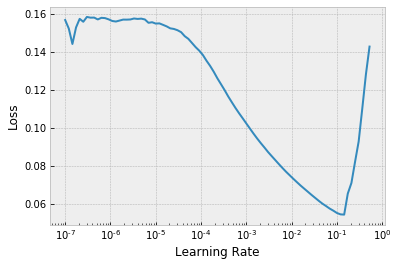

In [ ]:
%%time
learn.lr_find()

Running the following cell a few times and storing the model if it is better than the previous one

In [ ]:
%%time
# learn.fit_one_cycle(5, 5e-2)
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.162939,0.302681,00:00
1,0.141719,0.269532,00:00
2,0.123963,0.259743,00:00
3,0.099949,0.257936,00:00
4,0.086223,0.254300,00:00


CPU times: user 278 ms, sys: 156 µs, total: 278 ms
Wall time: 318 ms


In [ ]:
learn.save("model-1")

CPU times: user 3.78 s, sys: 38.9 ms, total: 3.82 s
Wall time: 4.28 s


(0.006918309628963471, 0.00015848931798245758)

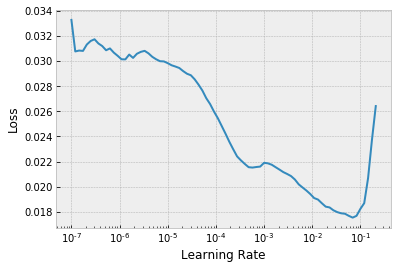

In [ ]:
%%time
learn.lr_find()

In [ ]:
#hide
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,time
0,0.033589,0.251459,00:00
1,0.032155,0.246288,00:00
2,0.025785,0.240472,00:00
3,0.021583,0.236030,00:00
4,0.018231,0.232026,00:00


In [ ]:
#hide
learn.save("model-2")

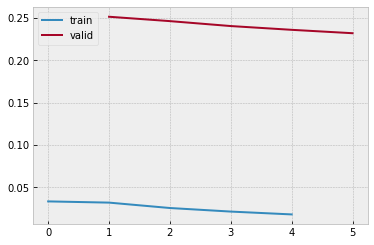

In [ ]:
learn.recorder.plot_loss(skip_start=0)

In [ ]:
#hide
learn.save("model-final")

Collecting predictions, `y_pred`, and ground truth, `y_true`, for all observations to approximate Kaggle's model evaluation.

In [ ]:
y_pred, y_true = learn.get_preds()

y_pred[:5], y_true[:5]

(tensor([[11.9432],
         [11.7848],
         [11.8594],
         [11.7840],
         [11.9642]]),
 tensor([[12.3967],
         [10.8590],
         [12.0287],
         [12.3673],
         [12.7293]]))

In [ ]:
#export
def predictions_vs_true_distribution_plots(y_pred:torch.Tensor, y_true:torch.Tensor, dep_var:str, bins:int=50):
    "Plots the predicted and true distributions side by side plus the residuals distribution"
    _y_p = y_pred.detach().numpy().ravel()
    _y_t = y_true.detach().numpy().ravel()

    fig, axs = plt.subplots(ncols=2, figsize=(14,4))
    ax = axs[0]
    ax.hist(_y_p, bins=bins, alpha=.5, label="pred")
    ax.hist(_y_t, bins=bins, alpha=.5, label="true")
    ax.set_xlabel(f"{dep_var}")
    ax.set_title(f"predicted vs true '{dep_var}'")
    ax.legend()

    ax = axs[1]
    ax.hist(_y_p-_y_t, bins=bins)
    ax.set_xlabel("Δ")
    ax.set_title(f"Δ-distribution: mean = {(_y_p-_y_t).mean():.2f}, std = {np.std(_y_p-_y_t):.2f}")
    plt.show()

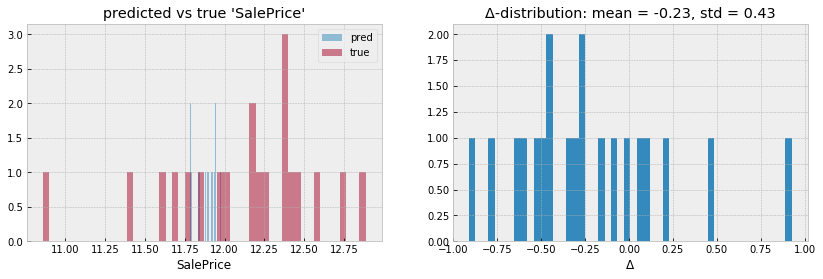

CPU times: user 669 ms, sys: 350 µs, total: 669 ms
Wall time: 673 ms


In [ ]:
%%time
predictions_vs_true_distribution_plots(y_pred, y_true, dep_var, bins=50)

Score of the current model predictions vs compared to the public leaderboard

,TeamId,TeamName,SubmissionDate,Score
7590,4210573,hsuanpingsun,2020-01-04 03:44:55,0.0
10044,4278029,Muhammet İkbal Elek,2020-01-20 13:09:34,0.0
9856,3740535,wentixiaogege,2020-01-19 03:37:57,0.0
4988,4155989,terracoda,2019-12-20 12:56:53,0.0
15086,2248598,predictor!,2020-02-15 13:51:49,0.0


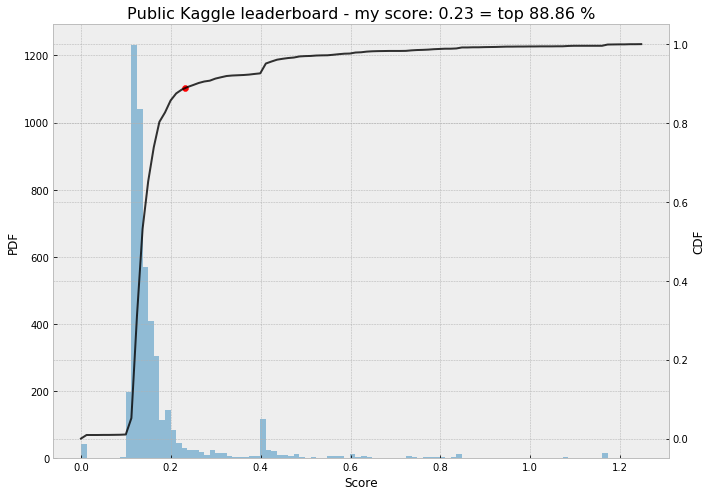

In [ ]:
my_score = loss_fun(y_pred, y_true).item()

show_leaderboard(fname_leaderboard, score_bounds=(None, 1.25), bins=100, user_score=my_score, user="my")

In [ ]:
assert my_score < .25

In [ ]:
#hide
ens = ensemble.RandomForestRegressor(n_estimators=100, max_features="sqrt", max_samples=.9, oob_score=True)

In [ ]:
#hide
ens.fit(to.train.xs.values, to.train.ys.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=0.9, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
#hide
ens.oob_score_

0.8055470296009681

In [ ]:
#hide
y_pred_ens = ens.predict(to.valid.xs.values)

In [ ]:
#hide
y_pred_ens[:5,None], y_true[:5]

(array([[12.12145842],
        [11.64465425],
        [11.90942825],
        [11.89877668],
        [12.57865662]]),
 tensor([[12.3967],
         [10.8590],
         [12.0287],
         [12.3673],
         [12.7293]]))

,TeamId,TeamName,SubmissionDate,Score
7590,4210573,hsuanpingsun,2020-01-04 03:44:55,0.0
10044,4278029,Muhammet İkbal Elek,2020-01-20 13:09:34,0.0
9856,3740535,wentixiaogege,2020-01-19 03:37:57,0.0
4988,4155989,terracoda,2019-12-20 12:56:53,0.0
15086,2248598,predictor!,2020-02-15 13:51:49,0.0


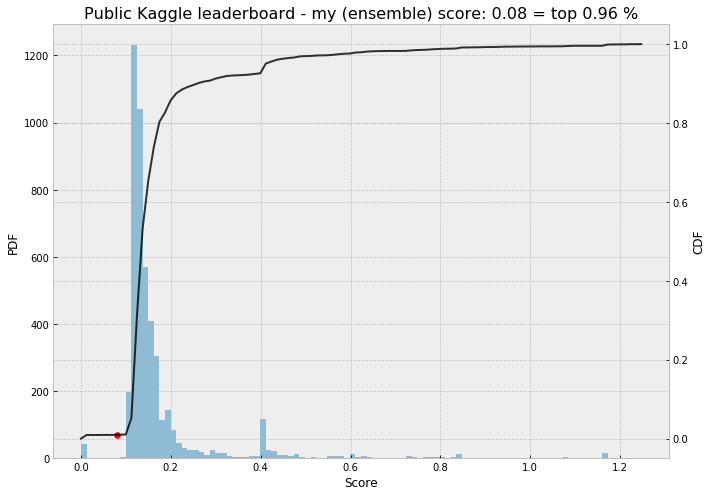

In [ ]:
#hide
my_score_ens = loss_fun(torch.from_numpy(y_pred_ens[:,None]).float(), y_true).item()

show_leaderboard(fname_leaderboard, score_bounds=(None, 1.25), bins=100, user_score=my_score_ens, 
                 user="my (ensemble)")

In [ ]:
#hide
with open("models/ensemble.pckl", "wb") as f:
    pickle.dump(ens, f)